In [1]:
import os
import sys

top_dir = os.path.split(os.getcwd())[0]
sys.path.append(top_dir)
sys.path.append(os.path.join(top_dir, "src"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
from yaml import safe_load


%load_ext lab_black

pd.options.display.float_format = "{:.3f}".format

In [3]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator


def autolabel(ax, orient="h", fmt="{:,f}", xytext=(5, -4), **kwargs):
    """Automatically labels the rectangles in a (vertical) bar chart.
    """

    for rect in ax.patches:
        if orient == "h":
            size = rect.get_width()
            xy = (size, rect.get_y())
        else:
            size = rect.get_height()
            xy = (rect.get_x() + rect.get_width() / 2, size)
        if size != 0:
            ax.annotate(
                fmt.format(size),
                xy=xy,
                xytext=xytext,
                textcoords="offset points",
                ha="center",
                va="bottom",
                **kwargs,
            )


def get_colnames(genres, metric_names):
    return [f"{name}_{genre}" for name in metric_names for genre in genres]


def build_df(results, metric_names):
    genres = results[metric_names[0]].keys()
    per_metric_dfs = []
    for genre in genres:
        per_genre_dfs = []
        for metric in metric_names:
            df = pd.DataFrame(np.array(results[metric][genre]), columns=["value"])
            df["metric"] = metric
            df["model"] = genre
            per_genre_dfs.append(df)
        per_metric_dfs.append(pd.concat(per_genre_dfs, axis=0))

    return pd.concat(per_metric_dfs, axis=0)[["model", "metric", "value"]]


def split_model_name(df):
    df["train_data"] = df["model_name"].str.split("_", expand=True)[0]
    df["# bars"] = (
        df["model_name"]
        .str.split("_", expand=True)[1]
        .str.replace("bars", "")
        .astype(int)
    )
    return df

In [4]:
# models were trained during 14th/15th of July
models = [m for m in os.listdir("../trained_models") if "Jazz2" in m or "Classic2" in m]

# Create a map between the model train dir and the training configuration
name_map = {}
for model in models:
    base = model.split("_")[0]
    with open(f"../trained_models/{model}/train_config.yaml") as f:
        config = safe_load(f)
        # fs = config["preprocessing"]["fs"]
        n_bars = config["preprocessing"]["n_bars"]
        name_map[model] = f"{base}_{n_bars}bars"

In [5]:
name_map

{'Classic2Pop_run_2022_07_21-07_07_54': 'Classic2Pop_1bars',
 'Classic2Pop_run_2022_07_22-03_17_49': 'Classic2Pop_2bars',
 'Classic2Pop_run_2022_07_22-20_22_11': 'Classic2Pop_4bars',
 'Classic2Pop_run_2022_07_23-13_10_55': 'Classic2Pop_8bars',
 'Jazz2Classic_run_2022_07_19-18_13_50': 'Jazz2Classic_1bars',
 'Jazz2Classic_run_2022_07_20-03_41_44': 'Jazz2Classic_2bars',
 'Jazz2Classic_run_2022_07_20-11_23_12': 'Jazz2Classic_4bars',
 'Jazz2Classic_run_2022_07_20-18_29_25': 'Jazz2Classic_8bars',
 'Jazz2Pop_run_2022_07_16-19_09_34': 'Jazz2Pop_1bars',
 'Jazz2Pop_run_2022_07_18-08_09_20': 'Jazz2Pop_2bars',
 'Jazz2Pop_run_2022_07_18-15_46_27': 'Jazz2Pop_4bars',
 'Jazz2Pop_run_2022_07_18-22_39_29': 'Jazz2Pop_8bars'}

In [6]:
base_results_fpath = "../results/single_bodhidharma/{}_bars"
nano_df = []
macro_df = []
tonnetz_df = []


# Load the results
for b in [1, 2, 4, 8]:
    results_fpath = base_results_fpath.format(str(b))
    for model_name in os.listdir(results_fpath):
        fname = os.listdir(os.path.join(results_fpath, model_name))[0]
        fpath = os.path.join(results_fpath, model_name, fname)

        with open(fpath, "r") as f:
            results = json.load(f)

        # Create dataframes
        chromas = build_df(results, ["chroma_similarities"])
        tonnetz_distances = build_df(results, ["tonnetz_distances"])
        style_macro = build_df(
            results, ["macro_time_pitch_diff", "macro_onset_duration"]
        )
        style_per_song = build_df(
            results, ["per_song_time_pitch_diff", "per_song_onset_duration"]
        )

        nano_metrics = pd.concat([chromas, style_per_song], axis=0)
        nano_metrics["model_name"] = name_map.get(model_name)
        tonnetz_distances["model_name"] = name_map.get(model_name)
        style_macro["model_name"] = name_map.get(model_name)

        nano_df.append(nano_metrics[nano_metrics["model_name"].notna()])
        tonnetz_df.append(tonnetz_distances[tonnetz_distances["model_name"].notna()])
        macro_df.append(style_macro[style_macro["model_name"].notna()])

nano_df = split_model_name(pd.concat(nano_df, axis=0))
tonnetz_df = split_model_name(pd.concat(tonnetz_df, axis=0))
macro_df = split_model_name(pd.concat(macro_df, axis=0))

In [7]:
def make_summary(df):
    """Helper function to calculate the mean value for each model"""
    gb = df.groupby("model_name")["value"].mean().reset_index()

    name_split = (
        gb["model_name"]
        .str.split("_", expand=True)
        .rename(columns={0: "model", 1: "n_bars"})
    )
    name_split["n_bars"] = name_split["n_bars"].str.replace("bars", "").astype(int)
    return pd.concat([name_split, gb.drop(columns="model_name")], axis=1).pivot_table(
        index="model", columns="n_bars"
    )

## Nano metrics

In [8]:
nano_map = {
    "chroma_similarities": "Chroma-Similarity",
    "per_song_time_pitch_diff": "Time-Pitch Difference",
    "per_song_onset_duration": "Onset-Duration",
}
nano_df["Metric"] = nano_df["metric"].replace(nano_map)

nano_j2p = nano_df[nano_df["model_name"].str.lower().str.contains("jazz2pop")]
nano_j2c = nano_df[nano_df["model_name"].str.lower().str.contains("jazz2classic")]
nano_c2p = nano_df[nano_df["model_name"].str.lower().str.contains("classic2pop")]

In [25]:
nano_agg = (
    nano_df.groupby(["# bars", "Metric"], as_index=False)
    .agg(mean=("value", "mean"), std=("value", "std"))
    .pivot_table(index=["Metric"], columns=["# bars"])
)
# nano_agg.columns = nano_agg.columns.droplevel()
nano_agg

mean                     std                  
# bars                    1     2     4     8     1     2     4     8
Metric                                                               
Chroma-Similarity     0.382 0.626 0.541 0.590 0.230 0.086 0.137 0.119
Onset-Duration        0.112 0.083 0.067 0.113 0.145 0.196 0.140 0.198
Time-Pitch Difference 0.285 0.327 0.401 0.397 0.193 0.153 0.114 0.090

Text(0, 0.5, 'Cosine similarity')

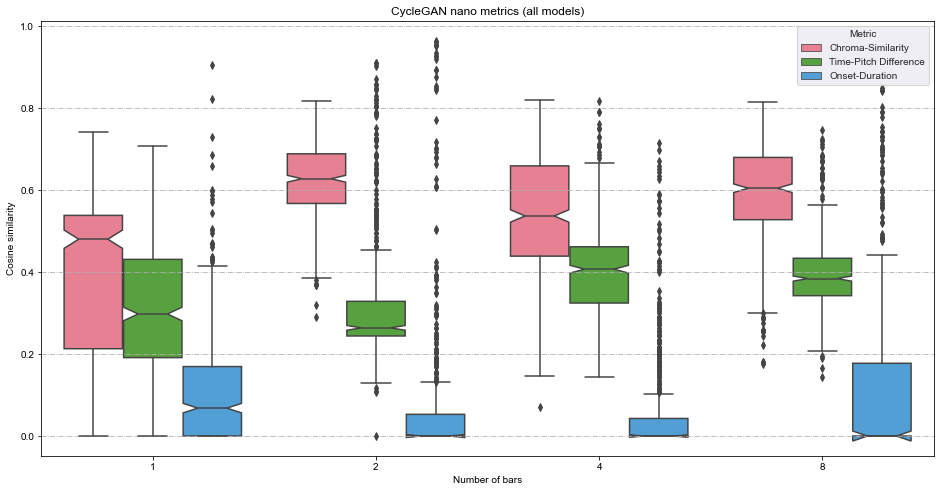

In [10]:
fig, ax = plt.subplots(figsize=(16, 8))

sns.set_style("darkgrid")

palette = sns.color_palette("husl", 3)

ax = sns.boxplot(
    x="# bars",
    y="value",
    hue="Metric",
    data=nano_df,
    ax=ax,
    notch=True,
    palette=palette,
)
ax.yaxis.grid(True, linestyle="-.")
ax.set_title("CycleGAN nano metrics (all models)")
ax.set_xlabel("Number of bars")
ax.set_ylabel("Cosine similarity")

### individual

Text(0, 0.5, 'Cosine similarity')

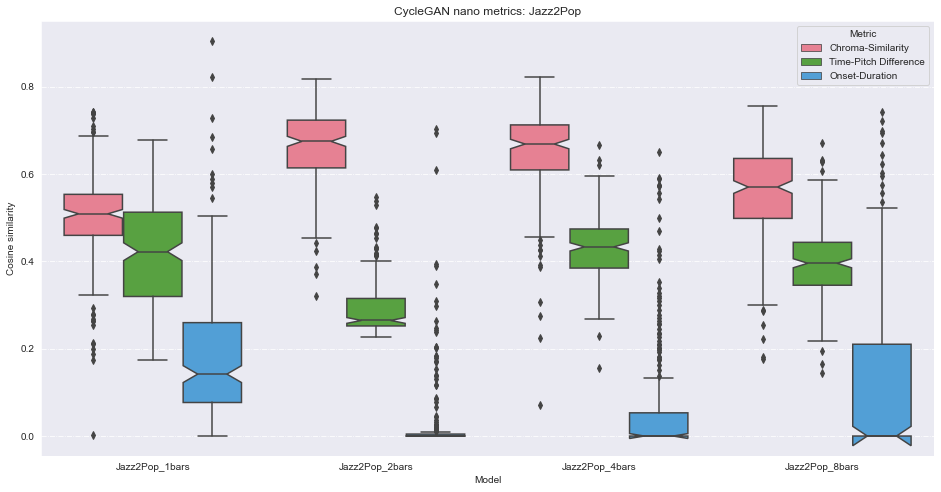

In [11]:
fig, ax = plt.subplots(figsize=(16, 8))

palette = sns.color_palette("husl", 3)


ax = sns.boxplot(
    x="model_name",
    y="value",
    hue="Metric",
    data=nano_j2p,
    ax=ax,
    notch=True,
    palette=palette,
)
ax.yaxis.grid(True, linestyle="-.")
ax.set_title("CycleGAN nano metrics: Jazz2Pop")
ax.set_xlabel("Model")
ax.set_ylabel("Cosine similarity")

Text(0, 0.5, 'Cosine similarity')

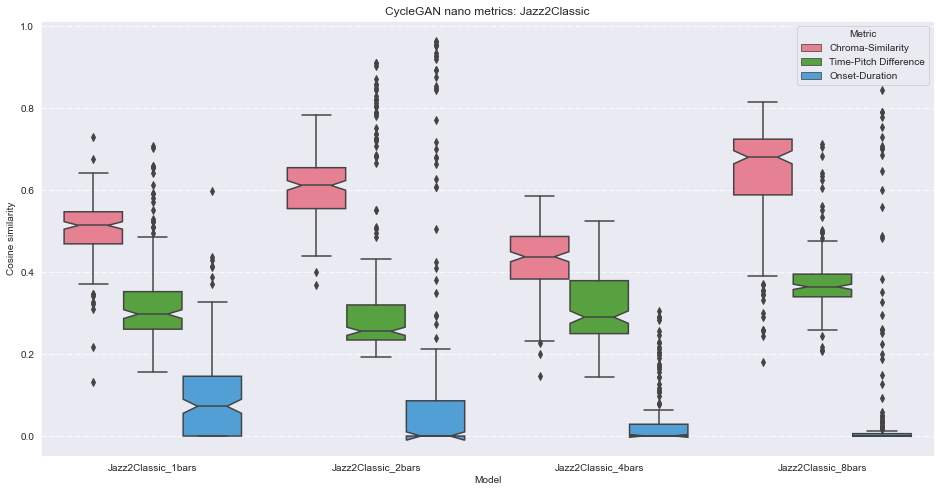

In [12]:
fig, ax = plt.subplots(figsize=(16, 8))

palette = sns.color_palette("husl", 3)


ax = sns.boxplot(
    x="model_name",
    y="value",
    hue="Metric",
    data=nano_j2c,
    ax=ax,
    notch=True,
    palette=palette,
)
ax.yaxis.grid(True, linestyle="-.")
ax.set_title("CycleGAN nano metrics: Jazz2Classic")
ax.set_xlabel("Model")
ax.set_ylabel("Cosine similarity")

Text(0, 0.5, 'Cosine similarity')

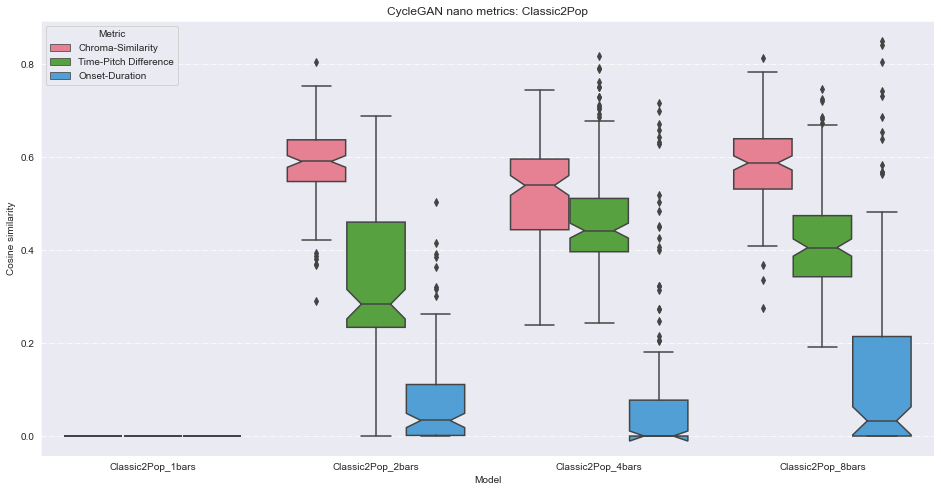

In [13]:
fig, ax = plt.subplots(figsize=(16, 8))

palette = sns.color_palette("husl", 3)


ax = sns.boxplot(
    x="model_name",
    y="value",
    hue="Metric",
    data=nano_c2p,
    ax=ax,
    notch=True,
    palette=palette,
)
ax.yaxis.grid(True, linestyle="-.")
ax.set_title("CycleGAN nano metrics: Classic2Pop")
ax.set_xlabel("Model")
ax.set_ylabel("Cosine similarity")

## Tonnetz

In [29]:
tonnetz_summary = (
    tonnetz_df.groupby(["# bars", "metric"], as_index=False)
    .agg(mean=("value", "mean"), std=("value", "std"))
    .pivot_table(index=["metric"], columns=["# bars"])
)
# tonnetz_summary.columns = tonnetz_summary.columns.droplevel()
tonnetz_summary

mean                     std                  
# bars                1     2     4     8     1     2     4     8
metric                                                           
tonnetz_distances 0.008 0.009 0.009 0.009 0.003 0.003 0.003 0.003

No handles with labels found to put in legend.


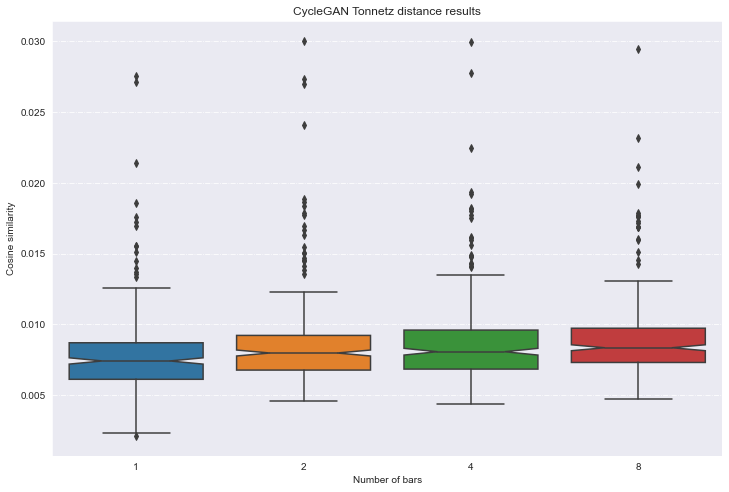

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))

palette = sns.color_palette("tab10", 4)

ax = sns.boxplot(
    x="# bars",
    y="value",
    # hue="model_name",
    data=tonnetz_df,
    ax=ax,
    notch=True,
    palette=palette,
)
ax.yaxis.grid(True, linestyle="-.")
ax.set_title("CycleGAN Tonnetz distance results")
ax.set_xlabel("Number of bars")
ax.set_ylabel("Cosine similarity")
ax.legend().remove()

plt.show()

No handles with labels found to put in legend.


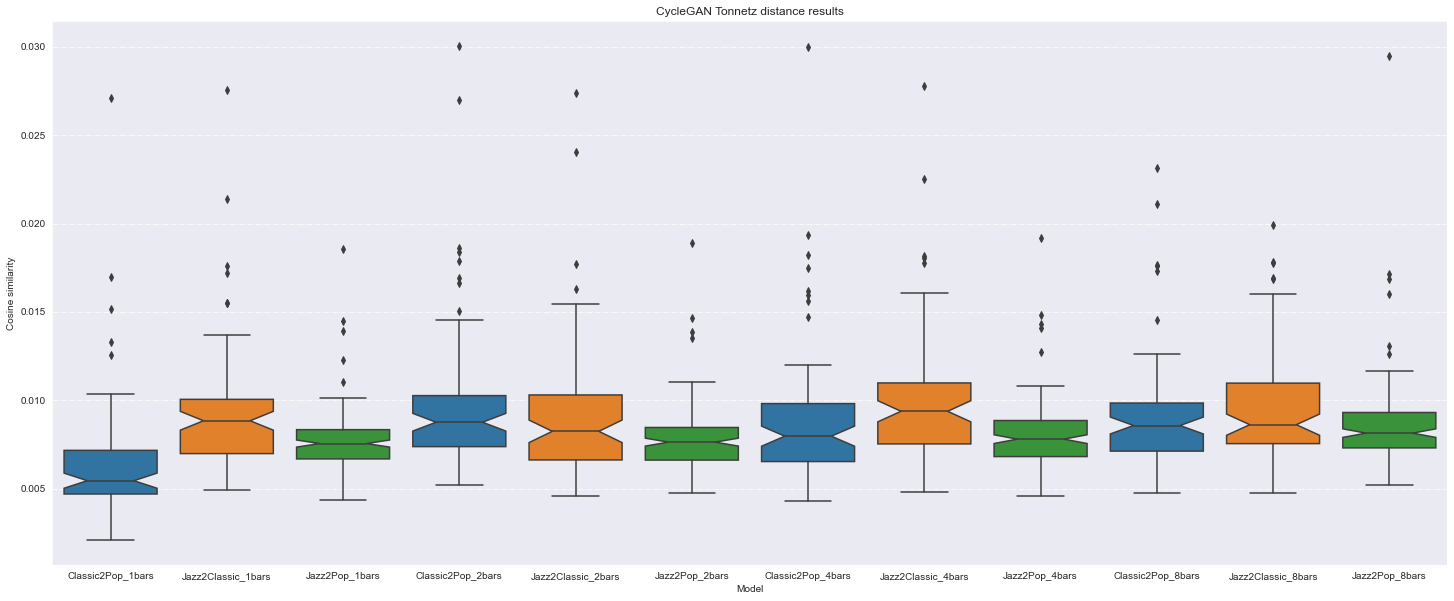

In [16]:
fig, ax = plt.subplots(figsize=(25, 10))

palette = sns.color_palette("tab10", 3)

ax = sns.boxplot(
    x="model_name",
    y="value",
    # hue="model_name",
    data=tonnetz_df,
    ax=ax,
    notch=True,
    palette=palette,
)
ax.yaxis.grid(True, linestyle="-.")
ax.set_title("CycleGAN Tonnetz distance results")
ax.set_xlabel("Model")
ax.set_ylabel("Cosine similarity")
ax.legend().remove()

plt.show()

## Macro df

In [17]:
mmap = {
    "macro_time_pitch_diff": "Time-Pitch Difference",
    "macro_onset_duration": "Onset-Duration",
}
macro_df["Metric"] = macro_df["metric"].replace(mmap)

macro_summary = (
    macro_df.groupby(["# bars", "Metric"], as_index=False)["value"]
    .mean()
    .pivot_table(index=["Metric"], columns=["# bars"])
)
macro_summary.columns = macro_summary.columns.droplevel()
macro_summary

# bars,1,2,4,8
Metric,,,,
Onset-Duration,0.328,0.353,0.380,0.454
Time-Pitch Difference,0.421,0.481,0.609,0.591


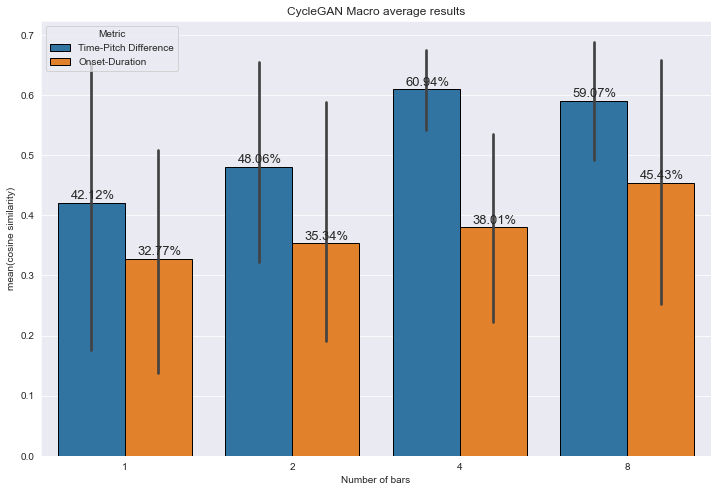

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))

palette = sns.color_palette("tab10", 3)

ax = sns.barplot(
    x="# bars", y="value", hue="Metric", data=macro_df, ec="k", lw=1, palette=palette,
)
autolabel(ax, orient="v", fmt="{:.2%}", xytext=(1, 1), size=13)
# ax.legend(loc="lower center")

ax.set_title("CycleGAN Macro average results")
ax.set_xlabel("Number of bars")
ax.set_ylabel("mean(cosine similarity)")

plt.show()

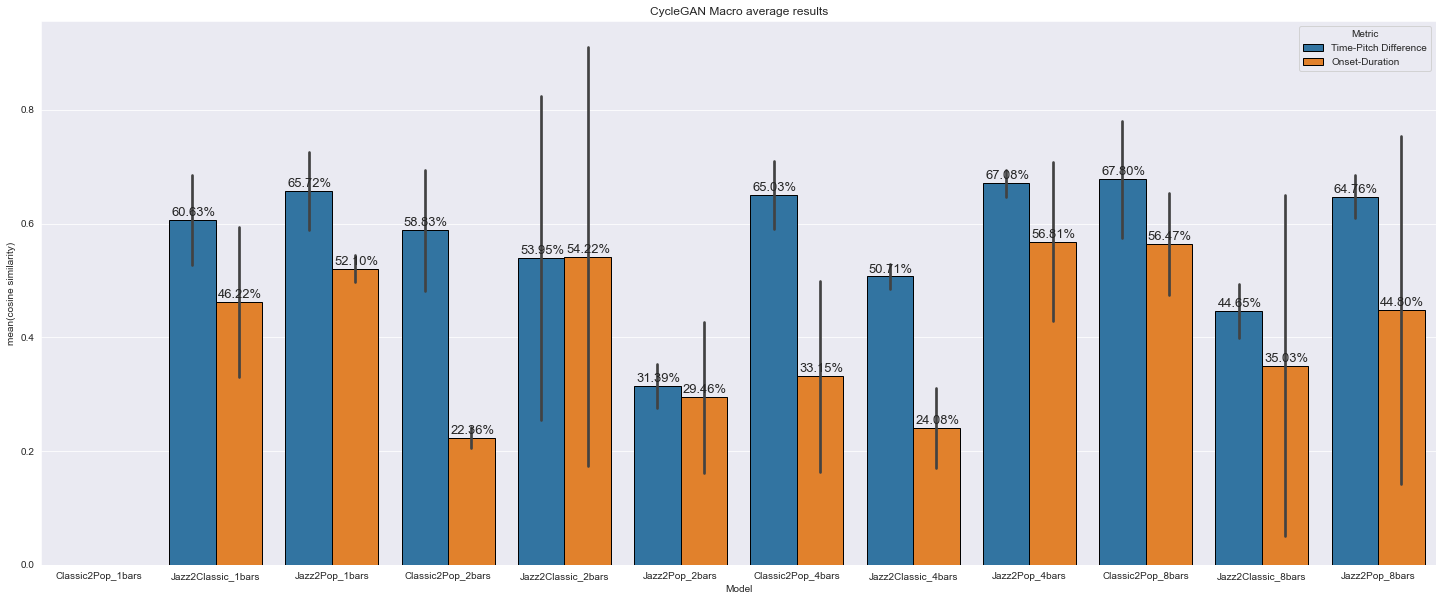

In [19]:
fig, ax = plt.subplots(figsize=(25, 10))

palette = sns.color_palette("tab10", 3)

ax = sns.barplot(
    x="model_name",
    y="value",
    hue="Metric",
    data=macro_df,
    ec="k",
    lw=1,
    palette=palette,
)
autolabel(ax, orient="v", fmt="{:.2%}", xytext=(1, 1), size=13)
# ax.legend(loc="lower center")

ax.set_title("CycleGAN Macro average results")
ax.set_xlabel("Model")
ax.set_ylabel("mean(cosine similarity)")

plt.show()